In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.2 on the current Colab Runtime...
2024-04-11 19:47:55 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz [169654402/169654402] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [352]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × AMD Ryzen 5 4500U with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


In [185]:
import Pkg
Pkg.add("SDDP")
Pkg.add("HiGHS")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [186]:
using SDDP, HiGHS, Statistics 

In [187]:
expm1.([-0.134, 0.06, 0.254])

3-element Vector{Float64}:
 -0.12540993539666598
  0.06183654654535962
  0.2891718042678043

In [188]:
1.06^5 *55

73.60240676800001

In [319]:
function asset_management_simple()

    goal = 70

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                              
            ],
        ),
        lower_bound = -1_800.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.05]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out == 55)
            @stageobjective(subproblem, 0)
        elseif 1 < stage < 11
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in == stocks.out + bonds.out
            )
            @stageobjective(subproblem, 0)
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in - over + short == goal
            )
            @stageobjective(subproblem, -over + 4 * short)
        end
    end
    SDDP.train(model; iteration_limit =900, log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_simple()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 31
  state variables : 2
  scenarios       : 5.90490e+04
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [5, 7]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [3, 5]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 4e+00]
  bounds range     [2e+03, 2e+03]
  rhs range        [6e+01, 7e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 31 nodes.
 Node indices: (1, 1), ..., (11, 3)


In [190]:
1.06^4 *55

69.43623280000001

In [401]:
function asset_management_merton()

    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.34 0.38 0.28],
                [0.34 0.38 0.28; 0.34 0.38 0.28; 0.34 0.38 0.28],
                [0.34 0.38 0.28; 0.34 0.38 0.28; 0.34 0.38 0.28],
                [0.34 0.38 0.28; 0.34 0.38 0.28; 0.34 0.38 0.28],  
                [0.34 0.38 0.28; 0.34 0.38 0.28; 0.34 0.38 0.28],                                
            ],
        ),
        lower_bound = -1_800.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.04]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)


        #@variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 40
        desired_limit = 60
  
        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
        # @constraint(subproblem, acceptable + desired + above_desired == consumption)

        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + acceptable + desired + above_desired == 100)
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage < 6
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        end
    end
    SDDP.train(model; log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [8, 10]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [6, 8]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [2e+01, 2e+03]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
---------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [362]:
function asset_management_merton_deterministic()
    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                
            ],
        ),
        lower_bound = -200.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock_deterministic = [1, 1.06, 0.866, 1.254,1.06,1.06]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)
       # @variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 50
        desired_limit = 70

        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
       # @constraint(subproblem, acceptable + desired + above_desired == consumption)

        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + acceptable + desired + above_desired == 100)
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage < 6
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        end
    end
    SDDP.train(model; log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton_deterministic()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [8, 10]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [6, 8]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [2e+01, 2e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
---------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [402]:
SDDP.calculate_bound(model)

-356.3425452001174

In [331]:
SDDP.numerical_stability_report(model)

numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [2e+03, 2e+03]
  rhs range        [2e-15, 1e+01]
  - rhs range contains small coefficients
Very large or small absolute values of coefficients
can cause numerical stability issues. Consider
reformulating the model.


In [209]:
rule = SDDP.DecisionRule(model; node = (1,1))

A decision rule for node (1, 1)

In [210]:
solution = SDDP.evaluate(
    rule;
    incoming_state = Dict(:stocks => 30.0),
    noise = 50.0,
    #controls_to_record = [:hydro_generation, :thermal_generation],
)

(stage_objective = 0.0, outgoing_state = Dict(:bonds => 0.0, :stocks => 10.0), controls = Dict{Any, Any}())

In [403]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    1000,
    # A list of names to record the values of.
    [:stocks, :bonds, :acceptable, :desired, :above_desired],
    skip_undefined_variables=true
)

replication = 23
stage =4
simulations[replication][stage]

Dict{Symbol, Any} with 11 entries:
  :bonds           => State{Float64}(0.0, 0.0)
  :bellman_term    => -201.409
  :node_index      => (4, 3)
  :objective_state => nothing
  :belief          => Dict((4, 3)=>1.0)
  :stage_objective => -94.4264
  :acceptable      => 31.4755
  :above_desired   => 0.0
  :noise_term      => nothing
  :stocks          => State{Float64}(74.9956, 62.569)
  :desired         => 0.0

In [366]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Stocks") do data
    return data[:stocks].out
end

SDDP.plot(plt)


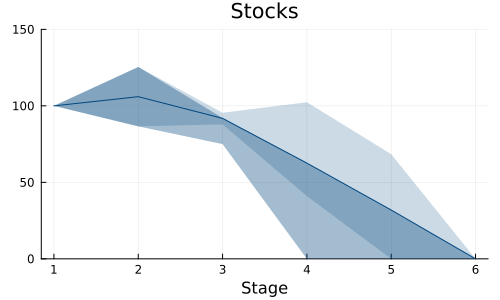

In [404]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Stocks") do data
        return data[:stocks].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

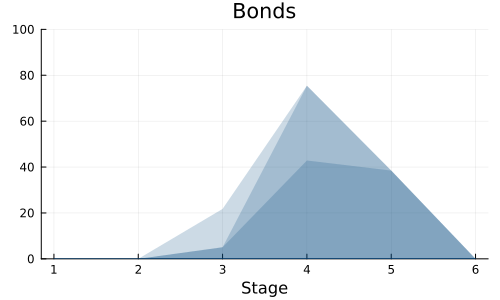

In [405]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Bonds") do data
        return data[:bonds].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 100),
    layout = (1, 2),
)

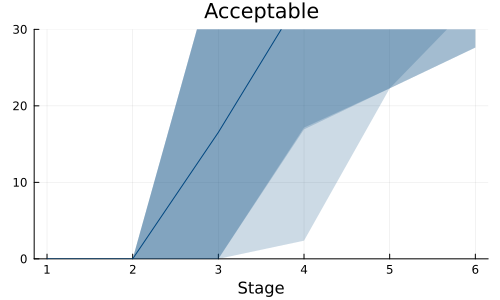

In [406]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Acceptable") do data
        return data[:acceptable]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

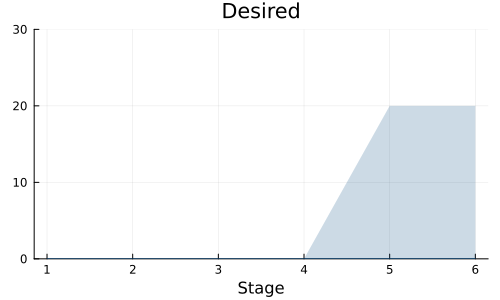

In [407]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Desired") do data
        return data[:desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

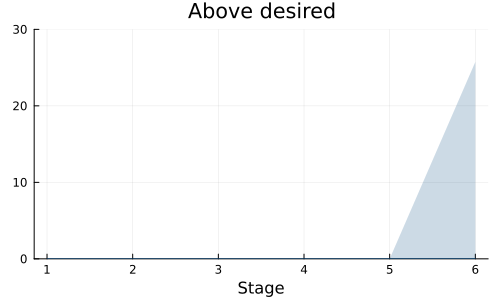

In [408]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Above desired") do data
        return data[:above_desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

In [375]:
n_stages = 6
stocks = zeros(1000,n_stages)

for scenario in 1:1000
    for stage in 1:n_stages
        stocks[scenario,stage] = simulations[scenario][stage][:stocks].out
    end
end

bonds = zeros(1000,n_stages)

for scenario in 1:1000
    for stage in 1:n_stages
        bonds[scenario,stage] = simulations[scenario][stage][:bonds].out
    end
end

#= consumption = zeros(1000,n_stages)

for scenario in 1:1000   
    for t in 1:6 
        consumption[scenario,t] = simulations[scenario][t][:consumption]
    end
end =#



In [379]:
t = 6

6

In [385]:
total_wealth = sum(stack([stocks[:,t], bonds[:,t]]),dims=2)
total_wealth

1000×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [381]:
quantile(stocks[:,t],[0.05,0.25,0.5,0.75,0.95])

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [382]:
quantile(stocks[:,t] ./ total_wealth[:],[0.05,0.25,0.5,0.75,0.95])

ArgumentError: ArgumentError: quantiles are undefined in presence of NaNs or missing values

In [351]:
consumption_percentile = zeros(5,6)

for t in 1:6
    consumption_percentile[:,t] = quantile(skipmissing(consumption[:,t]),[0.05,0.25,0.5,0.75,0.95])
end

consumption_percentile

5×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0   7.29735
 0.0  0.0  0.0  0.0  0.0  10.2129
 0.0  0.0  0.0  0.0  0.0  12.5008
 0.0  0.0  0.0  0.0  0.0  15.3012
 0.0  0.0  0.0  0.0  0.0  22.1567

In [299]:
total_wealth = zeros(6,5)

for t in 1:6
    total_wealth[t,:] = quantile(sum(stack([stocks[:,t], bonds[:,1]]),dims=2),[0.05,0.25,0.5,0.75,0.95])
end

total_wealth

6×5 Matrix{Float64}:
 10.0      10.0      10.0     10.0     10.0
  8.66      8.66     10.6     12.54    12.54
  7.49956   9.1796   10.8596  13.2924  15.7252
  6.49462   9.40445  11.5112  13.618   16.6687
  6.8843    9.96872  11.7932  14.4351  17.6688
  0.0       0.0       0.0      0.0      0.0

In [314]:
x̂ = -1:0.5:2
ŷ = x̂ .^ 2

N = length(x̂)
model = Model(HiGHS.Optimizer);
@variable(model, -1 <= x <= 2)
@variable(model, y)
@variable(model, 0 <= λ[1:N] <= 1)
@objective(model, Max, y)
@constraints(model, begin
           x == sum(x̂[i] * λ[i] for i in 1:N)
           y == sum(ŷ[i] * λ[i] for i in 1:N)
           sum(λ) == 1
           λ in SOS2()
       end)


(x + λ[1] + 0.5 λ[2] - 0.5 λ[4] - λ[5] - 1.5 λ[6] - 2 λ[7] == 0, y - λ[1] - 0.25 λ[2] - 0.25 λ[4] - λ[5] - 2.25 λ[6] - 4 λ[7] == 0, λ[1] + λ[2] + λ[3] + λ[4] + λ[5] + λ[6] + λ[7] == 1, [λ[1], λ[2], λ[3], λ[4], λ[5], λ[6], λ[7]] in MathOptInterface.SOS2{Float64}([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]))

In [315]:
optimize!(model)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 4e+00]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 2e+00]
  RHS    [1e+00, 1e+00]
Presolving model
10 rows, 14 cols, 39 nonzeros  0s
9 rows, 13 cols, 39 nonzeros  0s

Solving MIP model with:
   9 rows
   13 cols (5 binary, 0 integer, 0 implied int., 8 continuous)
   39 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   8.75            -inf                 inf        0      0      0         0     0.0s
 T       0       0         0   0.00%   8.75            4                118.75%        0      0      0         3     0.0s

Solving report
  Status            Optimal
  Primal bound      4
  Dual bound        4
  Gap            

In [316]:
objective_value(model)

4.0

In [317]:
value(x)

2.0

In [318]:
value(y)

4.0

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />